In [2]:
import pandas as pd
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.ensemble import ExtraTreesClassifier

# Importando a database
df = pd.read_csv('_data/dataset_2021-5-26-10-14.csv', sep='\t', encoding = 'utf-8')

# Escolhendo as features que considero importantes
X = df[['default_3months', 'ioi_36months', 'ioi_3months', 'valor_por_vencer',
       'valor_vencido', 'valor_quitado', 'quant_protestos', 'valor_protestos',
       'quant_acao_judicial', 'acao_judicial_valor', 'dividas_vencidas_valor',
       'dividas_vencidas_qtd', 'falencia_concordata_qtd', 'tipo_sociedade',
       'opcao_tributaria', 'valor_total_pedido']]

# Transformando features string em features binárias
X = pd.get_dummies(X)
y = df["default"]

# Separando o dataset entre treino e validação
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Classificadores a serem utilizados nos testes
names = ["Nearest Neighbors", "Decision Tree", "Random Forest", "Neural Net", "AdaBoost", "Naive Bayes", "QDA"]

classifiers = [
    KNeighborsClassifier(3),
    DecisionTreeClassifier(max_depth=8, max_features=22),
    RandomForestClassifier(max_depth=8, n_estimators=20, max_features=22),
    MLPClassifier(alpha=1e-05, hidden_layer_sizes=(5, 2), random_state=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

# Treinar cada um dos classificadores e analisar a performance
trained_models = {}
for name, classifier in zip(names, classifiers):
    classifier.fit(X_train, y_train)
    trained_models[name] = classifier
    print(f'Score classificador {name}: {classifier.score(X_test, y_test):.2f}')


Score classificador Nearest Neighbors: 0.84
Score classificador Decision Tree: 0.86
Score classificador Random Forest: 0.86
Score classificador Neural Net: 0.76
Score classificador AdaBoost: 0.86
Score classificador Naive Bayes: 0.19
Score classificador QDA: 0.22


/home/rafaelcostaf/.local/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


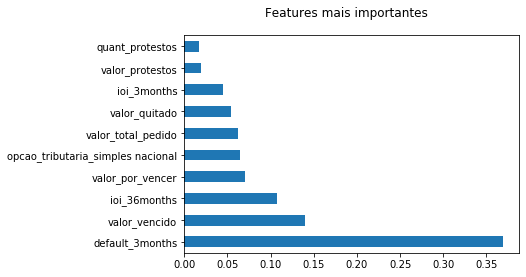

Score final do classificador: 0.89


In [19]:
import matplotlib.pyplot as plt
import pickle

# Melhor classificador foi o decision tree, vamos usar ele. 
# Agora para analisar as features realmente importantes, vamos utiizar uma técnica chamada de feature importance, 
# que analisa a importância relativa de cada uma das features no modelo
feat_importances = pd.Series(trained_models['Random Forest'].feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.suptitle('Features mais importantes')
plt.show()

most_imp_keys = feat_importances.nlargest(10).keys()

# Escolhendo finalmente as features mais importantes
X_f = pd.get_dummies(df)[most_imp_keys]

y_f = df["default"]

# Separando o dataset entre treino e validação
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(X_f, y_f, test_size=0.2, random_state=1)

# Treinando o classificador apenas com as features mais importantes
classifier_f = RandomForestClassifier(max_depth=64,  n_estimators=64, max_features=10)
classifier_f.fit(X_train_f, y_train_f)
print(f'Score final do classificador: {classifier_f.score(X_test_f, y_test_f):.2f}')

# Salvando o modelo para predição
save_dict = {'model': classifier_f, 'features': list(most_imp_keys), 'columns': pd.get_dummies(df).columns}
pickle.dump(save_dict, open('_model/default_classifier', 'wb'))



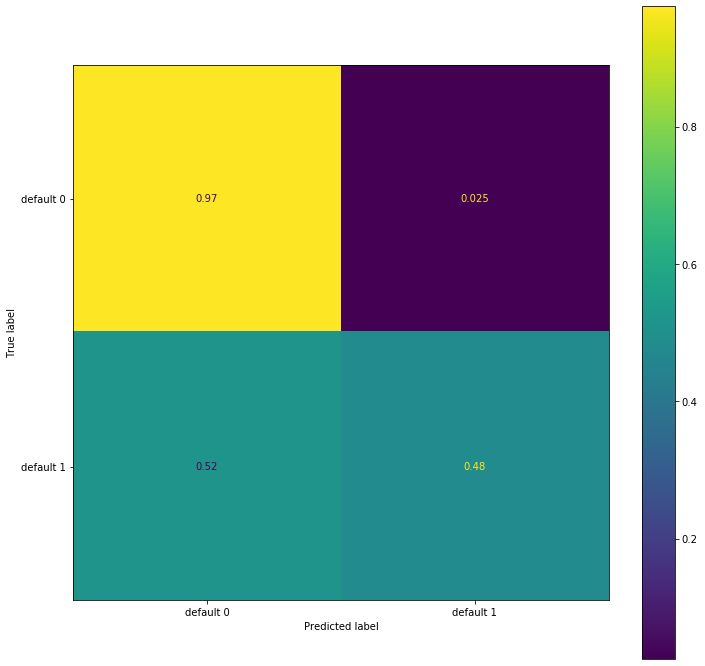

Defaults 0 corretamente previstos: 97.47%
Defaults 1 corretamente previstos: 48.47%
Defaults 0 previstos como Default 1: 2.53%
Defaults 1 previstos como Default 0: 51.53%
Valor Revertido pela previsão de default: R$41,454,073.57
Valor de vendas perdidas pela previsão de default errônea: R$11,651,352.27
Considerando taxa de lucro de 20%, valor de prejuízo pelas previsões erroneas: R$2,330,270.45


In [20]:
import numpy as np
from sklearn.metrics import plot_confusion_matrix, confusion_matrix

# Análise de previsão de default, falsos positivos e falsos negativos
y_pred = classifier_f.predict(X_test_f)
fig, ax = plt.subplots(figsize=(12, 12))
plot_confusion_matrix(
        classifier_f, 
        X_test_f, 
        y_test,
        display_labels=['default 0', 'default 1'],
        normalize='true',
        ax=ax)
plt.show()

# Matriz de confução para análise do comportamento do modelo
cf_mat = confusion_matrix(y_test_f, y_pred, normalize='true')

print(f'Defaults 0 corretamente previstos: {cf_mat[0, 0]:.2%}')
print(f'Defaults 1 corretamente previstos: {cf_mat[1, 1]:.2%}')
print(f'Defaults 0 previstos como Default 1: {cf_mat[0, 1]:.2%}')
print(f'Defaults 1 previstos como Default 0: {cf_mat[1, 0]:.2%}')

# Logica para separação da database e cálculo dos valores recuperados e perdidos
bool_error = np.logical_not(np.logical_and(y_pred == 1, y_test_f.to_numpy() == 1))
bool_default = np.logical_not(np.logical_and(y_pred == 1, y_test_f.to_numpy() == 0))

# Separando a database e somando os valores totais de pedido
prev_def_1 = X_test_f['valor_total_pedido'].mask(bool_error, 0).sum()
prev_def_0 = X_test_f['valor_total_pedido'].mask(bool_default, 0).sum()
print(f'Valor Revertido pela previsão de default: R${prev_def_1:,.2f}')
print(f'Valor de vendas perdidas pela previsão de default errônea: R${prev_def_0:,.2f}')
print(f'Considerando taxa de lucro de 20%, valor de prejuízo pelas previsões erroneas: R${prev_def_0*0.2:,.2f}')

